In [1]:
from IPython import display
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

EpisodeStats = namedtuple('Stats', ['episode_lengths', 'episode_rewards'])


def plot_value_function(V, title = "Value Function"):

    min_x = 11 # min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize = (20, 10))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.coolwarm, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [2]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]



            
        
        

In [3]:
class BlackjackEnv(gym.Env):

    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

    
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [4]:
def mc_prediction(policy, env, num_episodes, discount_factor = 1.0):

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    
    for i_episode in range(num_episodes):
        observation = env.reset()[0]
        
        episodes = []
        for i in range(100):
            action = policy(observation)
            next_observation, reward, done, _, x = env.step(action)
            episodes.append((observation, action, reward))
            if done:
                break
            observation = next_observation
        
        # obtain unique observation set
        observations = set([x[0] for x in episodes])
        for i, observation in enumerate(observations):
            # first occurence of the observation
            idx = episodes.index([episode for episode in episodes if episode[0] == observation][0])
            
            Q = sum([episode[2] * discount_factor ** i for episode in episodes[idx:]])
            
            returns_sum[observation] += Q
            returns_count[observation] += 1.0
            
            V[observation] = returns_sum[observation] / returns_count[observation]
                
    return V

In [5]:
env = gym.make('Blackjack-v1')

# A policy that sticks if the player score is >= 20 and hits otherwise.
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

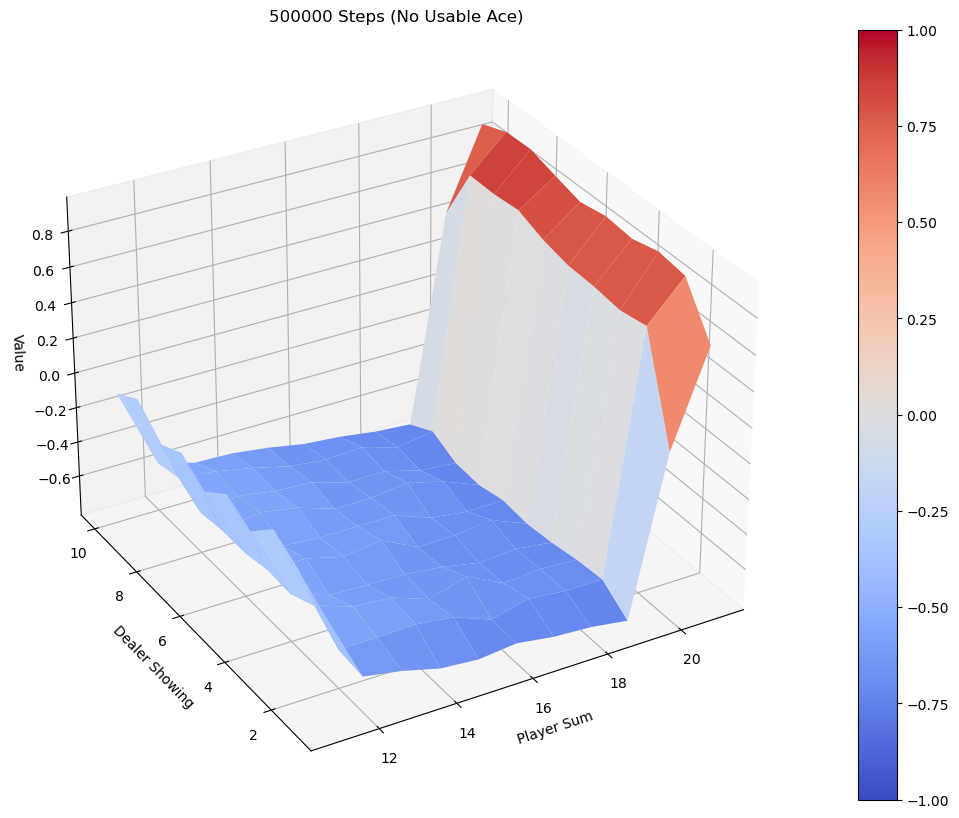

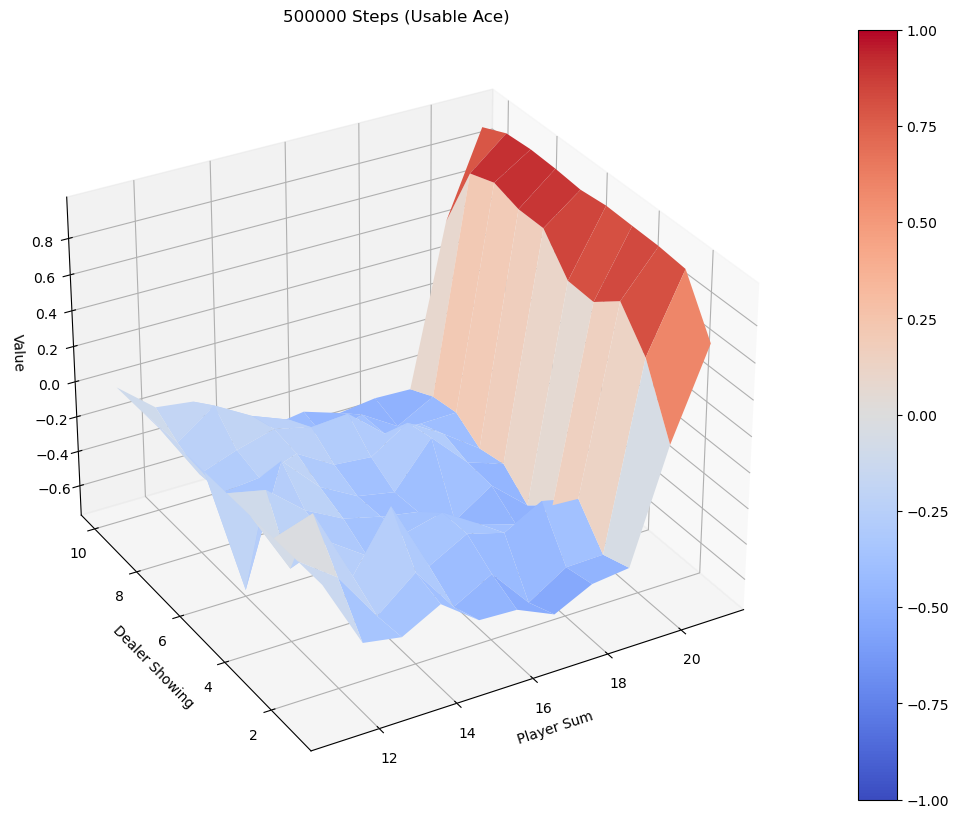

In [6]:
V_10000 = mc_prediction(sample_policy, env, num_episodes = 10000)
#plot_value_function(V_10k, title = '10000 Steps')

V_50000 = mc_prediction(sample_policy, env, num_episodes = 50000)
plot_value_function(V_50000, title = '500000 Steps')

In [ ]:
#print(V_10000)

In [ ]:
#print(V_50000)

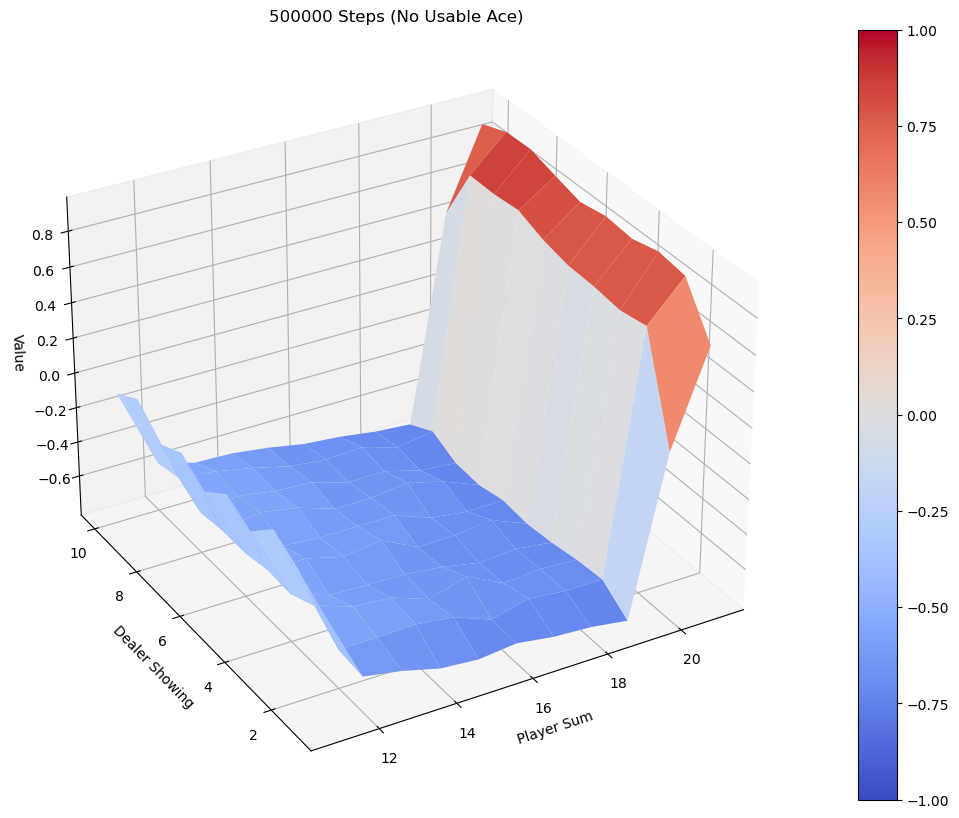

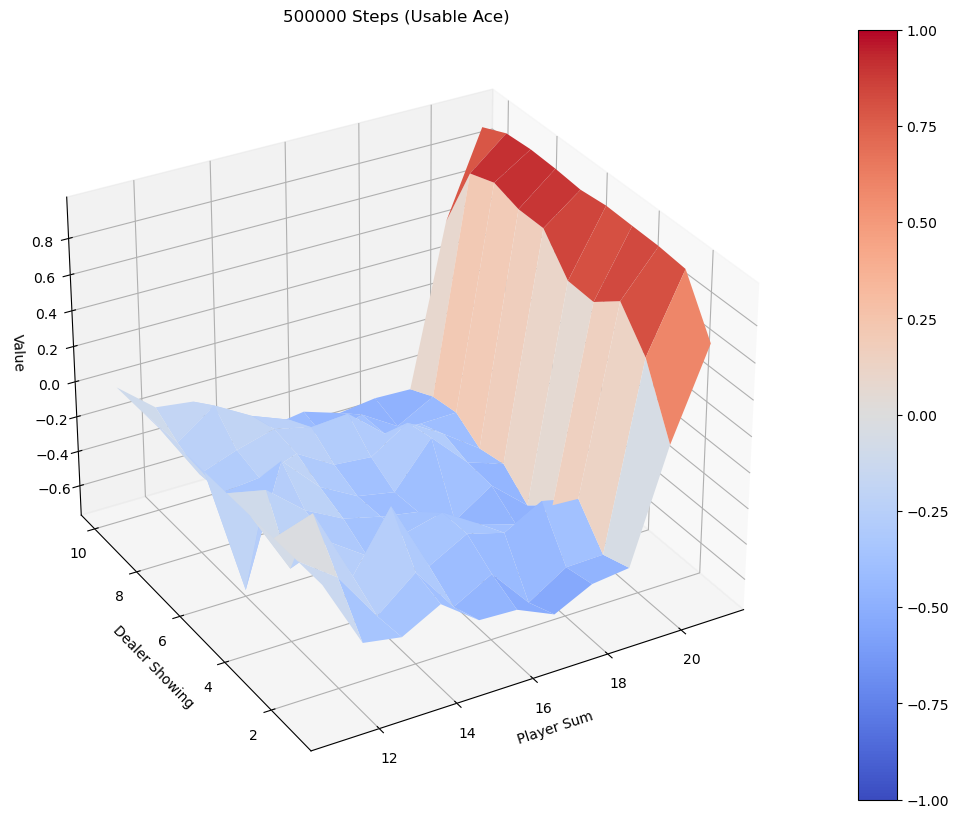

In [7]:
plot_value_function(V_50000, title = '500000 Steps')

In [8]:
import pandas as pd
data1=pd.DataFrame.from_dict(V_50000, orient='index')
data1["Reward"]=data1[0]
value50000=data1.drop(0,axis=1)
data2=pd.DataFrame.from_dict(V_10000, orient='index')
data2["Reward"]=data2[0]
value10000=data2.drop(0,axis=1)

In [9]:
value50000

,Reward
"(17, 3, False)",-0.703214
"(18, 1, False)",-0.764595
"(13, 1, False)",-0.667447
"(17, 1, False)",-0.751456
"(21, 4, True)",0.982456
...,...
"(11, 6, True)",0.000000
"(11, 7, True)",0.000000
"(11, 8, True)",0.000000
"(11, 9, True)",0.000000


In [ ]:
value10000

In [10]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    
    def policy_fn(observation):        
        props = np.ones(nA, dtype = float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        props[best_action] += 1. - epsilon
        return props
        
    return policy_fn

In [11]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor = 1.0, epsilon = 0.1):
    
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i_episode in range(num_episodes):
        observation = env.reset()[0]
        
        episodes = []
        for i in range(100):
            props = policy(observation)
            action = np.random.choice(np.arange(len(props)), p = props)
            next_observation, reward, done, _,x = env.step(action)
            episodes.append((observation, action, reward))
            
            if done:
                break
            observation = next_observation
        
        # find the unique observation
        pairs = set([(episode[0], episode[1]) for episode in episodes])
        for (observation, action) in pairs:
            pair = (observation, action)
            # find the first occurence of the observation
            idx = episodes.index([episode for episode in episodes if episode[0] == observation and episode[1] == action][0])
            V = sum([reward[2] * discount_factor ** i for i, reward in enumerate(episodes[idx:])])
            
            returns_sum[pair] += V
            returns_count[pair] += 1.
            
            Q[observation][action] = returns_sum[pair] / returns_count[pair]
    
    return Q, policy

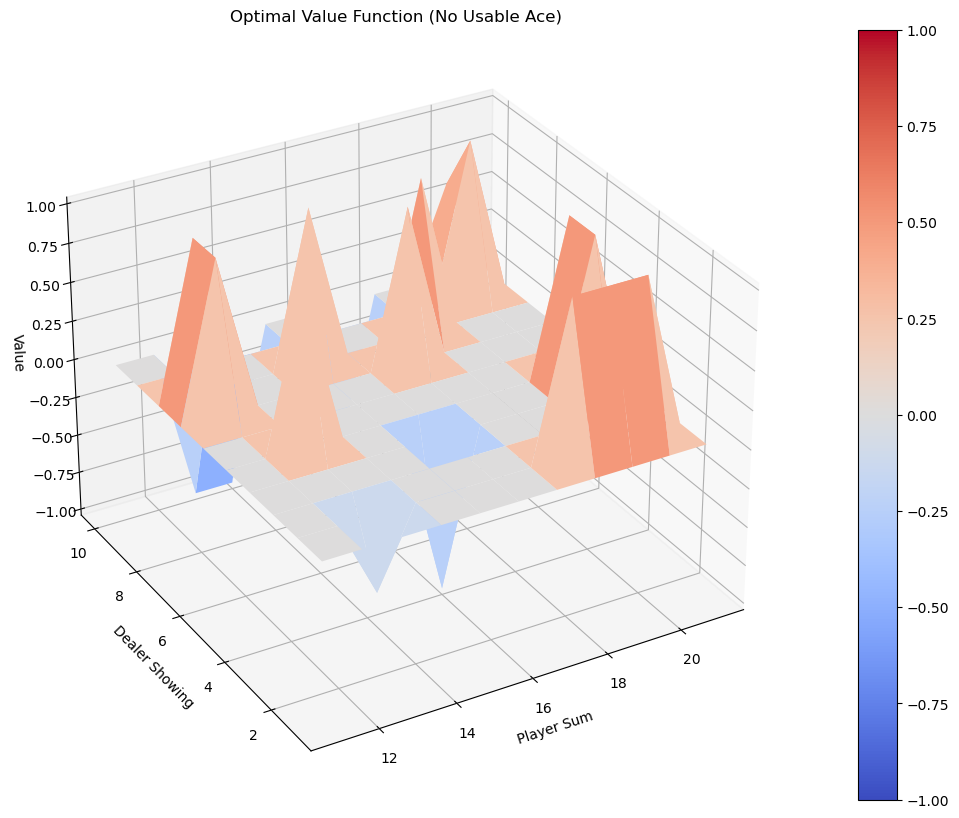

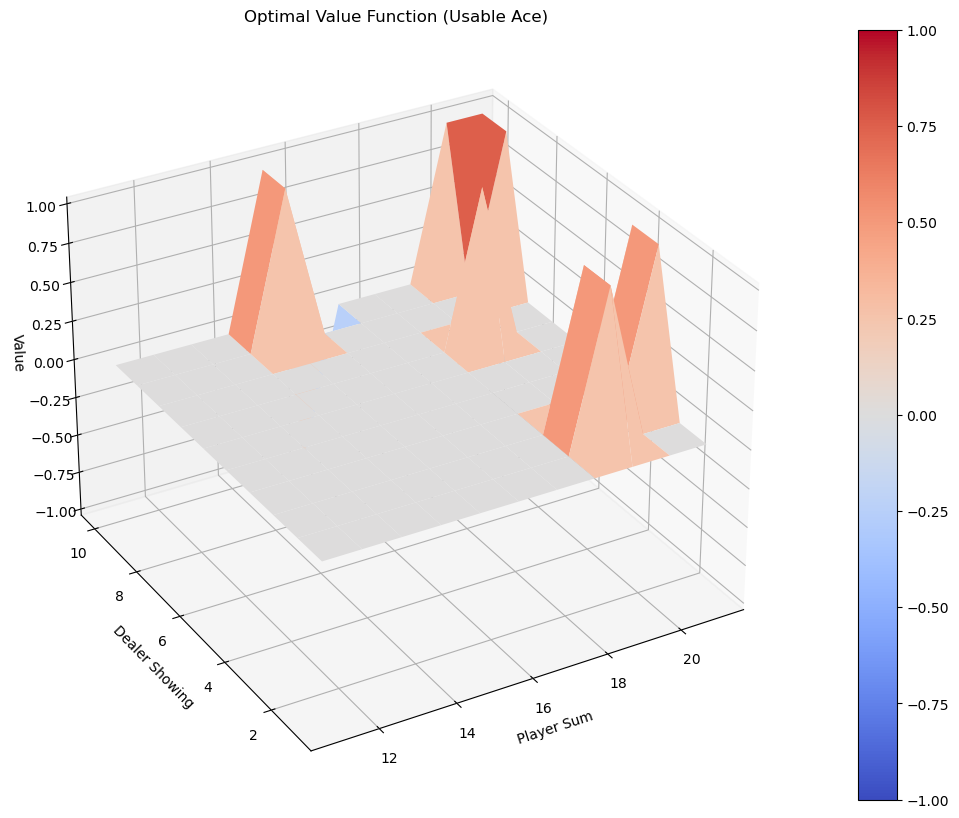

In [12]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes = 100, epsilon = 0.1)
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title = 'Optimal Value Function')

In [13]:
import time
#Taking a random State
env = gym.make('Blackjack-v1',render_mode="human")
state=env.reset()[0]
print("State: ",state)
actions=policy(state)
print(actions)
if(actions[0]>actions[1]):
    print("Best Action: ","Stand")
else:
    print("Best Action: Hit")
    
env.render()
#time.sleep(5)

State:  (15, 4, False)
[0.95 0.05]
Best Action:  Stand


In [14]:
env.close()
